In [1]:
import urllib.request
import pandas as pd

url = "https://www.n2yo.com/browse/?y=2021&m=01"
fp = urllib.request.urlopen(url)
mybytes = fp.read()

mystr = mybytes.decode("utf8")
fp.close()

print(mystr)



<!doctype html>
<html lang="en">
<HEAD>
<meta name="viewport" content="width=device-width, initial-scale=1" />
<meta charset="utf-8">
<TITLE>BROWSE SATELLITES BY LAUNCH DATE</TITLE>
<META name="keywords" content="Satellite, satellites, satellite tracking, Tracking, Position,  ISS, Shuttle, Mir, Hubble, Space shuttle, suitsat, geostationary, GOES, NOAA, TV satellites, weather, Iridium, Intelsat, Globalstar, amateur radio, GPS, Military satellites, cubesat">
<META name="description" content="Browse the satellite database by satellite's launch year: 2021 and month: 01. Select any satellite for additional info or tracking">
<link href="/footable/css/footable.core.css" rel="stylesheet" type="text/css" />
<link rel="stylesheet" href="/css/style.css" type="text/css">
<script src="/js/jquery-1.11.js"></script>
<script src="/footable/js/footable.js" type="text/javascript"></script>

</HEAD>
<BODY>
<script type="text/javascript">

$(function () {
 
    $('.footable').footable();
 
});

</scrip

In [11]:
urls = [f"https://www.n2yo.com/browse/?y=2021&m={month}" for month in range(1, 13)]
urls += [f"https://www.n2yo.com/browse/?y=2020&m={month}" for month in range(1, 13)]
urls += [f"https://www.n2yo.com/browse/?y=2019&m={month}" for month in range(1, 13)]
month_dfs = []
for url in urls:
    print(f"reading {url}")
    tables = pd.read_html(url)
    month_dfs.append(tables[2])
    
df = pd.concat(month_dfs)

reading https://www.n2yo.com/browse/?y=2021&m=1
reading https://www.n2yo.com/browse/?y=2021&m=2
reading https://www.n2yo.com/browse/?y=2021&m=3
reading https://www.n2yo.com/browse/?y=2021&m=4
reading https://www.n2yo.com/browse/?y=2021&m=5
reading https://www.n2yo.com/browse/?y=2021&m=6
reading https://www.n2yo.com/browse/?y=2021&m=7
reading https://www.n2yo.com/browse/?y=2021&m=8
reading https://www.n2yo.com/browse/?y=2021&m=9
reading https://www.n2yo.com/browse/?y=2021&m=10
reading https://www.n2yo.com/browse/?y=2021&m=11
reading https://www.n2yo.com/browse/?y=2021&m=12
reading https://www.n2yo.com/browse/?y=2020&m=1
reading https://www.n2yo.com/browse/?y=2020&m=2
reading https://www.n2yo.com/browse/?y=2020&m=3
reading https://www.n2yo.com/browse/?y=2020&m=4
reading https://www.n2yo.com/browse/?y=2020&m=5
reading https://www.n2yo.com/browse/?y=2020&m=6
reading https://www.n2yo.com/browse/?y=2020&m=7
reading https://www.n2yo.com/browse/?y=2020&m=8
reading https://www.n2yo.com/browse/?

In [12]:
df

,Name,Launch date (YYYY-MM-DD),Status,Action
0,TURKSAT 5A,2021-01-08,IN ORBIT,TRACK IT
1,FALCON 9 R/B,2021-01-08,IN ORBIT,TRACK IT
2,CAPE-3,2021-01-17,IN ORBIT,TRACK IT
3,POLARCUBE,2021-01-17,IN ORBIT,TRACK IT
4,RADFXSAT-2 (AO-109),2021-01-17,IN ORBIT,TRACK IT
...,...,...,...,...
70,SJ-20,2019-12-27,IN ORBIT,TRACK IT
71,CZ-5 R/B,2019-12-27,IN ORBIT,TRACK IT
72,BLOCK DM-SL DEB,2019-12-24,IN ORBIT,TRACK IT
73,BLOCK DM-SL DEB,2019-12-24,IN ORBIT,TRACK IT


In [3]:


from bs4 import BeautifulSoup
soup = BeautifulSoup(mystr, 'html.parser')

print(soup.prettify())

<!DOCTYPE html>
<html lang="en">
 <head>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <meta charset="utf-8"/>
  <title>
   BROWSE SATELLITES BY LAUNCH DATE
  </title>
  <meta content="Satellite, satellites, satellite tracking, Tracking, Position,  ISS, Shuttle, Mir, Hubble, Space shuttle, suitsat, geostationary, GOES, NOAA, TV satellites, weather, Iridium, Intelsat, Globalstar, amateur radio, GPS, Military satellites, cubesat" name="keywords"/>
  <meta content="Browse the satellite database by satellite's launch year: 2021 and month: 01. Select any satellite for additional info or tracking" name="description"/>
  <link href="/footable/css/footable.core.css" rel="stylesheet" type="text/css"/>
  <link href="/css/style.css" rel="stylesheet" type="text/css"/>
  <script src="/js/jquery-1.11.js">
  </script>
  <script src="/footable/js/footable.js" type="text/javascript">
  </script>
 </head>
 <body>
  <script type="text/javascript">
   $(function () {
 
    $('.

In [ ]:
df.to_csv("../data/satellite_data.csv")

In [51]:
df = pd.read_csv("../data/satellite_data.csv").iloc[:, 1:]
df.head()

,Name,Launch date (YYYY-MM-DD),Status,Action
0,TURKSAT 5A,2021-01-08,IN ORBIT,TRACK IT
1,FALCON 9 R/B,2021-01-08,IN ORBIT,TRACK IT
2,CAPE-3,2021-01-17,IN ORBIT,TRACK IT
3,POLARCUBE,2021-01-17,IN ORBIT,TRACK IT
4,RADFXSAT-2 (AO-109),2021-01-17,IN ORBIT,TRACK IT


In [52]:
df.iloc[:, 1] = pd.to_datetime(df.iloc[:, 1])
df.columns = ['Name', 'launch_date', 'Status', 'Action']
df.head()

,Name,launch_date,Status,Action
0,TURKSAT 5A,2021-01-08,IN ORBIT,TRACK IT
1,FALCON 9 R/B,2021-01-08,IN ORBIT,TRACK IT
2,CAPE-3,2021-01-17,IN ORBIT,TRACK IT
3,POLARCUBE,2021-01-17,IN ORBIT,TRACK IT
4,RADFXSAT-2 (AO-109),2021-01-17,IN ORBIT,TRACK IT


In [54]:
import numpy as np
df = df[(np.logical_or(df["Name"].str.contains("SPACE").values, df["Name"].str.contains("ONEWEB")))]
df.head()

,Name,launch_date,Status,Action
96,SPACEBEE-52,2021-01-24,IN ORBIT,TRACK IT
97,SPACEBEE-46,2021-01-24,IN ORBIT,TRACK IT
98,SPACEBEE-47,2021-01-24,IN ORBIT,TRACK IT
99,SPACEBEE-59,2021-01-24,IN ORBIT,TRACK IT
100,SPACEBEE-62,2021-01-24,IN ORBIT,TRACK IT


In [62]:
df.Name.unique().shape

(512,)

In [55]:
weekly = df.groupby([pd.Grouper(key='launch_date', freq='W-MON')]).count().reset_index()
weekly["count"] = weekly["Name"]
weekly.head()

,launch_date,Name,Status,Action,count
0,2019-03-04,6,6,6,6
1,2019-03-11,0,0,0,0
2,2019-03-18,0,0,0,0
3,2019-03-25,0,0,0,0
4,2019-04-01,0,0,0,0


In [63]:
weekly["cdf"] = weekly["count"].cumsum()
weekly.index = weekly.launch_date
weekly.head()

,launch_date,Name,Status,Action,count,cdf
launch_date,,,,,,
2019-03-04,2019-03-04,6,6,6,6,6
2019-03-11,2019-03-11,0,0,0,0,6
2019-03-18,2019-03-18,0,0,0,0,6
2019-03-25,2019-03-25,0,0,0,0,6
2019-04-01,2019-04-01,0,0,0,0,6


<AxesSubplot:xlabel='launch_date'>

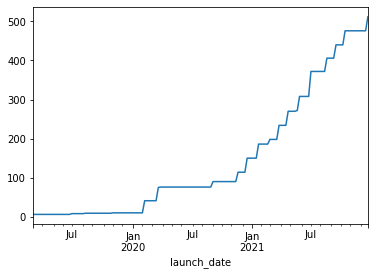

In [64]:
weekly["cdf"].plot() 